In [1]:
# 코랩을 사용하지 않으면 이 셀의 코드를 주석 처리하세요.
!git clone https://github.com/rickiepark/nlp-with-transformers.git
%cd nlp-with-transformers
from install import *
install_requirements(chapter=2)

fatal: destination path 'nlp-with-transformers' already exists and is not an empty directory.
/content/nlp-with-transformers
⏳ Installing base requirements ...
✅ Base requirements installed!
Using transformers v4.30.2
Using datasets v2.13.1
Using accelerate v0.21.0
Using sentencepiece v0.1.99
Using umap v0.5.3


## 2.1 데이터셋
### 2.1.1 허깅페이스 데이터셋 처음 사용하기

In [2]:
from datasets import list_datasets

all_datasets = list_datasets()
print(all_datasets[:10])

<ipython-input-2-9ccfb340d783>:3: FutureWarning: list_datasets is deprecated and will be removed in the next major version of datasets. Use 'huggingface_hub.list_datasets' instead.
  all_datasets = list_datasets()


['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc',
'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar',
'allegro_reviews']


In [3]:
from datasets import load_dataset

emotions = load_dataset("emotion")
emotions

  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [4]:
train_ds = emotions["train"]
print(train_ds)
print(train_ds[0])
print(train_ds.features)

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})
{'text': 'i didnt feel humiliated', 'label': 0}
{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness',
'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


### 2.1.2 데이터셋에서 데이터프레임으로

In [5]:
import pandas as pd
emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [6]:
def label_int2str(row) :
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


### 2.1.3 클래스 분포 살펴보기

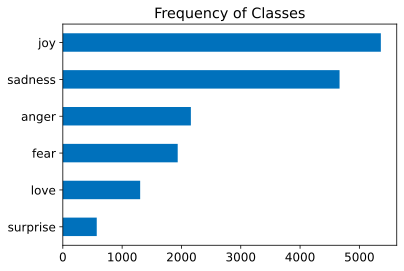

In [7]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

### 2.1.4 트윗 길이 확인

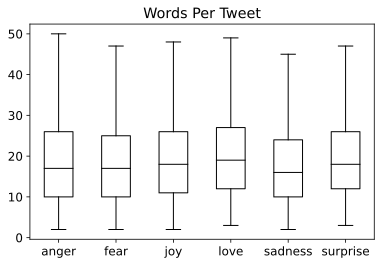

In [8]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

최대 문맥 크기 문제 없음 Good

In [9]:
emotions.reset_format()

## 2.2 텍스트에서 토큰으로
### 2.2.1 문자 토큰화

In [10]:
text = "Tokenizing text is a core task of NLP"
tokenized_text = list(text)
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ',
'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o',
'f', ' ', 'N', 'L', 'P']


In [11]:
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, 'L': 1, 'N': 2, 'P': 3, 'T': 4, 'a': 5, 'c': 6, 'e': 7, 'f': 8, 'g': 9,
'i': 10, 'k': 11, 'n': 12, 'o': 13, 'r': 14, 's': 15, 't': 16, 'x': 17, 'z': 18}


In [12]:
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[4, 13, 11, 7, 12, 10, 18, 10, 12, 9, 0, 16, 7, 17, 16, 0, 10, 15, 0, 5, 0, 6,
13, 14, 7, 0, 16, 5, 15, 11, 0, 13, 8, 0, 2, 1, 3]


In [13]:
import torch
import torch.nn.functional as F

input_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes = len(token2idx))
one_hot_encodings.shape

torch.Size([37, 19])

In [14]:
print(f"토큰: {tokenized_text[0]}")
print(f"텐서 인덱스: {input_ids[0]}")
print(f"원-핫 인코딩: {one_hot_encodings[0]}")

토큰: T
텐서 인덱스: 4
원-핫 인코딩: tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


### 2.2.2 단어 토큰화

In [15]:
tokenized_text = text.split()
print(tokenized_text)

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP']


### 2.2.3 부분단어 토큰화

In [16]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [17]:
from transformers import DistilBertTokenizer

distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)

In [18]:
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953,
2361, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [19]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl',
'##p', '[SEP]']


In [20]:
print(tokenizer.convert_tokens_to_string(tokens))
print(tokenizer.vocab_size)
print(tokenizer.model_max_length)
print(tokenizer.model_input_names)

[CLS] tokenizing text is a core task of nlp [SEP]
30522
512
['input_ids', 'attention_mask']


### 2.2.4 전체 데이터셋 토큰화하기

In [21]:
def tokenize(batch) :
    return tokenizer(batch["text"], padding=True, truncation=True)

print(tokenize(emotions["train"][:2]))

for i in range(2) :
    print(tokenizer.convert_ids_to_tokens(tokenize(emotions["train"][:2]).input_ids[i]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0,
0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000,
2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300,
102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
1, 1]]}
['[CLS]', 'i', 'didn', '##t', 'feel', 'humiliated', '[SEP]', '[PAD]', '[PAD]',
'[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]',
'[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
['[CLS]', 'i', 'can', 'go', 'from', 'feeling', 'so', 'hopeless', 'to', 'so',
'damned', 'hopeful', 'just', 'from', 'being', 'around', 'someone', 'who',
'cares', 'and', 'is', 'awake', '[SEP]']


In [22]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

print(emotions_encoded["train"].column_names)
print(emotions_encoded["train"][0])

['text', 'label', 'input_ids', 'attention_mask']
{'text': 'i didnt feel humiliated', 'label': 0, 'input_ids': [101, 1045, 2134,
2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


## 2.3 텍스트 분류 모델 훈련하기
### 2.3.1 트랜스포머를 특성 추출기로 사용하기
**사전 훈련된 모델 사용하기**

In [23]:
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

**마지막 은닉 상태 추출하기**

In [24]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(inputs['input_ids'])
print(tokenizer.convert_ids_to_tokens(inputs['input_ids'].tolist()[0]))
print(f"입력 텐서 크기: {inputs['input_ids'].size()}")

tensor([[ 101, 2023, 2003, 1037, 3231,  102]])
['[CLS]', 'this', 'is', 'a', 'test', '[SEP]']
입력 텐서 크기: torch.Size([1, 6])


In [25]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad() :
    outputs = model(**inputs)
print(outputs)
print(outputs.last_hidden_state.size()) # [batch_size, n_tokens, hidden_dim]

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ...,
-0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)
torch.Size([1, 6, 768])


In [26]:
outputs.last_hidden_state[:, 0].size()

torch.Size([1, 768])

In [27]:
def extract_hidden_states(batch) :
    # 모델 입력을 GPU로 옮깁니다.
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}

    # 마지막 은닉 상태를 추출합니다.
    with torch.no_grad() :
        last_hidden_state = model(**inputs).last_hidden_state
    # [CLS] 토큰에 대한 벡터를 반환합니다.
    return {"hidden_state": last_hidden_state[:, 0].cpu().numpy()}

In [28]:
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

**특성 행렬 만들기**

In [29]:
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

**훈련 세트 시각화하기**

In [30]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# 특성 스케일을 [0, 1] 범위로 조정합니다.
X_scaled = MinMaxScaler().fit_transform(X_train)
# UMAP 객체를 생성하고 훈련합니다.
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# 2D 임베딩의 데이터프레임을 만듭니다.
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,4.509254,6.754002,0
1,-3.020678,6.327965,0
2,5.420556,3.191638,3
3,-2.055451,3.958842,2
4,-3.163450,4.225528,3


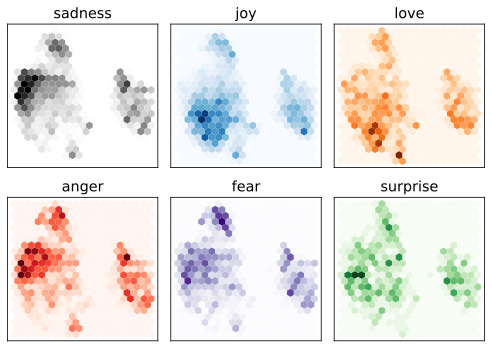

In [31]:
fig, axes = plt.subplots(2, 3, figsize=(7, 5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)) :
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

**간단한 분류 모델 훈련하기**

In [32]:
from sklearn.linear_model import LogisticRegression

# 수렴을 보장하기 위해 'max_iter'을 증가시킵니다.
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.634

In [33]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

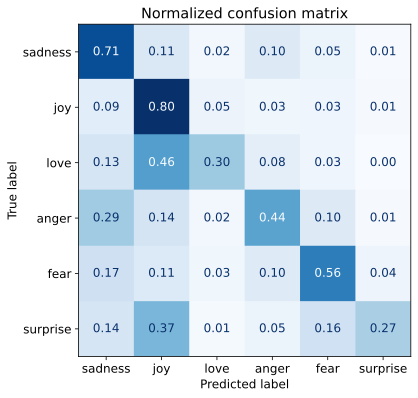

In [34]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels) :
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

### 2.3.2 트랜스포머 미세 튜닝하기
**사전 훈련된 모델 로드하기**

In [35]:
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification
        .from_pretrained(model_ckpt, num_labels=num_labels)
        .to(device))

**성공 지표 정의하기**

In [36]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred) :
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy" : acc, "f1" : f1}

**모델 훈련하기**

In [37]:
from huggingface_hub import notebook_login

notebook_login()

In [38]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  save_strategy="epoch",
                                  load_best_model_at_end=True,
                                  log_level="error")

In [39]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train()

/content/nlp-with-transformers/distilbert-base-uncased-finetuned-emotion is already a clone of https://huggingface.co/codeblue/distilbert-base-uncased-finetuned-emotion. Make sure you pull the latest changes with `repo.git_pull()`.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.832300,0.319284,0.903000,0.899025
2,0.248900,0.221974,0.921500,0.921662


TrainOutput(global_step=500, training_loss=0.5406072463989258, metrics={'train_runtime': 318.7846, 'train_samples_per_second': 100.381, 'train_steps_per_second': 1.568, 'total_flos': 720342861696000.0, 'train_loss': 0.5406072463989258, 'epoch': 2.0})

In [40]:
preds_output = trainer.predict(emotions_encoded["validation"])

In [41]:
preds_output.metrics

{'test_loss': 0.22197434306144714,
 'test_accuracy': 0.9215,
 'test_f1': 0.9216620892381366,
 'test_runtime': 4.023,
 'test_samples_per_second': 497.147,
 'test_steps_per_second': 7.954}

In [42]:
y_preds = np.argmax(preds_output.predictions, axis=1)

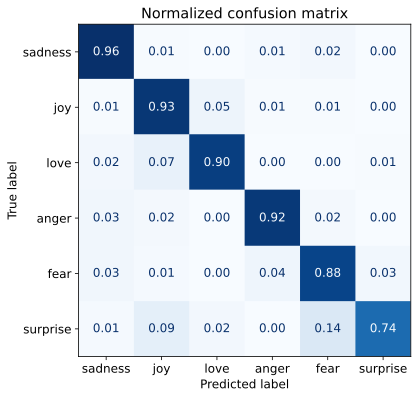

In [43]:
plot_confusion_matrix(y_preds, y_valid, labels)

**오류 분석**

In [44]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch) :
    # 모든 입력 텐서를 모델과 같은 장치로 이동합니다.
    inputs = {k:v.to(device) for k, v in batch.items()
        if k in tokenizer.model_input_names}

    with torch.no_grad() :
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                            reduction="none")

    # 다른 데이터셋 열과 호환되도록 출력을 CPU로 옮깁니다.
    return {"loss" : loss.cpu().numpy(),
            "predicted_label" : pred_label.cpu().numpy()}

In [45]:
# 데이터셋을 다시 파이토치 텐서로 변환합니다.
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])

# 손실 값을 계산합니다.
emotions_encoded["validation"] = emotions_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [47]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"].apply(label_int2str))

In [48]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
1950,i as representative of everything thats wrong ...,surprise,sadness,5.693632
1274,i am going to several holiday parties and i ca...,joy,sadness,5.548560
765,i feel super awkward and out of place right now,joy,sadness,5.496179
882,i feel badly about reneging on my commitment t...,love,sadness,5.284379
1963,i called myself pro life and voted for perry w...,joy,sadness,5.211735
1509,i guess this is a memoir so it feels like that...,joy,fear,5.174900
1500,i guess we would naturally feel a sense of lon...,anger,sadness,5.060926
465,i would eventually go in to these stores but i...,joy,fear,5.000473
1870,i guess i feel betrayed because i admired him ...,joy,sadness,4.997235
1801,i feel that he was being overshadowed by the s...,love,sadness,4.605439


In [49]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
394,i feel shamed that i hoped for one last christ...,sadness,sadness,0.016078
69,i have no extra money im worried all of the ti...,sadness,sadness,0.016119
697,i was missing him desperately and feeling idio...,sadness,sadness,0.016151
1368,i started this blog with pure intentions i mus...,sadness,sadness,0.016219
1152,i feel pathetic because i shouldn t complain a...,sadness,sadness,0.016223
1540,i wonder maybe he has this awesome excuse and ...,sadness,sadness,0.016238
953,i also feel ashamed at the hurt caused and ash...,sadness,sadness,0.016299
1452,i always feel guilty and come to one conclusio...,sadness,sadness,0.016327
1601,i feel so ungrateful when thinking saying thes...,sadness,sadness,0.016391
1663,i feel idiotic calling again though,sadness,sadness,0.016392


**모델 저장 및 공유**

In [50]:
trainer.push_to_hub(commit_message="Training completed!")

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 1.00/255M [00:00<?, ?B/s]

Upload file runs/Jul16_14-52-59_f4bcdd856230/events.out.tfevents.1689519183.f4bcdd856230.12277.0:   0%|       …

To https://huggingface.co/codeblue/distilbert-base-uncased-finetuned-emotion
   8835f2e..7a8d0f8  main -> main

   8835f2e..7a8d0f8  main -> main

To https://huggingface.co/codeblue/distilbert-base-uncased-finetuned-emotion
   7a8d0f8..b0be984  main -> main

   7a8d0f8..b0be984  main -> main



'https://huggingface.co/codeblue/distilbert-base-uncased-finetuned-emotion/commit/7a8d0f8b647c0b108799e9b1c7f83c48155f4c56'

In [52]:
from transformers import pipeline

model_id = "codeblue/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model=model_id)

In [53]:
custom_tweet = "They think I'm the most handsome.What should I do to understand how I feel."
preds = classifier(custom_tweet, return_all_scores=True)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


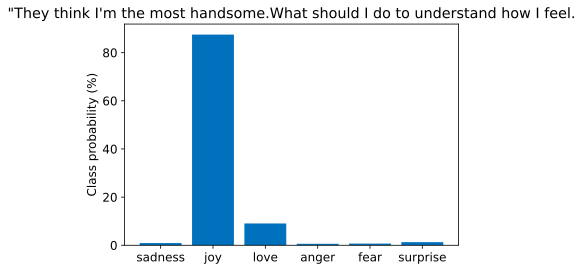

In [54]:
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}')
plt.ylabel("Class probability (%)")
plt.show()